In [299]:
#pip install Mordred

In [300]:
# %%time
# conda install rdkit

In [301]:
# from mordred import Calculator, descriptors
# from rdkit import Chem
# import re

In [310]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

import random as python_random

import seaborn as sns
import scipy as sp

from scipy import stats

from IPython.display import Image

# Section 1 - Dataset Explanation
## Source of Data
The dataset comes from Chemical Retrieval on the Web (CROW), and is specifically the database of polymers [1]. Each polymer page provides thermo-physical calculated data as well as SMILES. The data from these pages were extracted using a combination of Selenium to collect links and pd.read_html() to export html tables. Please see the file 'PolymerDataGenerator.ipynb' for the full code. To run the code, it is necessary to run it through Anaconda on a local machine to take advantage of the Chromedriver. It does not seem like there is a way to run the Driver in the virtual Jupyterlab. All outliers were evaluated for anomalies and fixed. For example, in some cases number ranges had the dash next to the number and this was read as a negative value for something meant to be positive such as density.

## Reliability of Data
The data used are calculated values determined by up-to-date modelling techniques. The Polymer Database website has articles that explain the methods for calculating these values and includes sources (an example using Tg: http://polymerdatabase.com/polymer%20physics/GIM-TG.html). Calculated values are used over the reported literature values because the calculated values are more complete. Looking at the table below, it can be seen that the predicted values are fairly close to the experimental values for Tg, and it is assumed that this is the case for the other calculated values [2]. Further, some values are theoretical and cannot be experimentally determined such as the van der Waals volume.

<img src="https://i.imgur.com/ZgDZAja.png" width=500>

Table is from http://polymerdatabase.com/polymer%20physics/GIM-TG.html

## Explorative Analysis
First the data is brought in. Then it is useful to look at the shape and head() to get an idea of what it looks like. It is also useful to look at the numeric data with describe().

In [311]:
## Read in data
df = pd.read_csv('PolymerData.csv')

## Dropping nothing column that showed up
dfPolymer = df.drop(['Unnamed: 0'], axis=1)
dfPolymer['POLYMER CLASS'].iloc[93] = 'Epoxy Resin'

print(dfPolymer.shape)
dfPolymer.head()


(248, 20)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,POLYMER CLASS,COMMON NAMES,STRUCTURE BASED NAME,CAS #,CurlySMILES,Molecular Weight of Repeat unit,Van-der-Waals Volume VvW,Molar Volume Vm,Density ρ,Solubility Parameter δ,Molar Cohesive Energy Ecoh,Glass Transition Temperature Tg,Molar Heat Capacity Cp,Entanglement Molecular Weight Me,Index of Refraction n,Monomer CAS,Monomer Common Names,Monomer SMILES,Std. InChI,Std. InChIKey
0,Polyvinylether,"Poly(vinyl butyral), (EXP DATA ONLY)","Poly[(2-propyl-1,3-dioxane-4,6-diyl)methylene]",63148-65-2,C1{-}CC(OC(CCC)O1)C{n+},141.21,NaN,125.00,1.135,22.05,63750.0,343.0,NaN,NaN,1.495,"9002-89-5, 123-72-8",Poly(vinylalcohol) + Butyraldehyde,C{-}C(O){n+}.O=CCCC,NaN,NaN
1,Polyvinylether,"Poly(vinyl formal), (EXP DATA ONLY)","Poly[(1,3-dioxane-4,6-diyl)methylene]",63450-15-7,C1{-}CC(OCO1)C{n+},99.12,NaN,79.85,1.240,NaN,NaN,353.0,NaN,NaN,1.490,"9002-89-5, 50-00-0",Poly(vinylalcohol) + Formaldehyde (- H2O),C{-}C(O){n+}.O=C,NaN,NaN
2,Polyvinylsulfide,"Poly(propyl vinyl thioether), Poly(vinyl propy...",Poly(propylthioethylene),NaN,C{-}C{n+}(SCCC),102.20,61.30,99.90,1.025,17.60,30950.0,250.5,196.0,NaN,1.545,16330-21-5,"Propyl vinyl thioether, 1-(Vinylsulfanyl)propane",CCCSC=C,"1S/C5H10S/c1-3-5-6-4-2/h4H,2-3,5H2,1H3",HWRMMWBUMQCMJK-UHFFFAOYSA-N
3,Polyvinylsulfide,"Poly(vinyl phenyl sulfide), Poly(phenylthioeth...",Poly[(vinylsulfanyl)benzene],NaN,C{-}C{n+}(Sc1ccccc1),136.22,76.21,115.70,1.180,19.85,45500.0,398.0,153.5,22800.0,1.655,1822-73-7,"Vinyl phenyl sulfide, Phenylthioethene, (Vinyl...",C=CSc1ccccc1,"1S/C8H8S/c1-2-9-8-6-4-3-5-7-8/h2-7H,1H2",GMPDOIGGGXSAPL-UHFFFAOYSA-N
4,Polyvinylsulfide,"Poly(methyl vinyl thioether), Poly(vinyl methy...",Poly(methylthioethylene),NaN,C{-}C{n+}(SC),74.15,40.77,66.15,1.125,18.20,22150.0,269.5,135.5,7150.0,1.580,1822-74-8,"Methyl vinyl thioether, (Methylthio)ethene",CSC=C,"1S/C3H6S/c1-3-4-2/h3H,1H2,2H3",AMBKPYJJYUKNFI-UHFFFAOYSA-N


In [312]:
dfPolymer.describe()

,Molecular Weight of Repeat unit,Van-der-Waals Volume VvW,Molar Volume Vm,Density ρ,Solubility Parameter δ,Molar Cohesive Energy Ecoh,Glass Transition Temperature Tg,Molar Heat Capacity Cp,Entanglement Molecular Weight Me,Index of Refraction n
count,246.000000,240.000000,242.000000,242.000000,242.000000,240.000000,246.000000,239.000000,204.000000,242.000000
mean,160.115163,92.562583,142.511501,1.150351,20.017975,59641.875000,318.081301,265.802981,16560.181373,1.519752
std,110.335825,65.118538,101.767185,0.205891,2.922718,46903.965657,85.708593,368.657030,22629.718290,0.062703
min,28.050000,12.250000,24.200000,0.855000,12.150000,7300.000000,140.000000,58.000000,194.500000,1.220000
25%,98.195000,53.112500,83.437500,1.026250,18.012500,31250.000000,248.125000,145.750000,2718.750000,1.480000
50%,134.370000,76.760000,118.800000,1.125000,19.575000,45250.000000,313.250000,212.000000,7800.000000,1.500000
75%,198.032500,113.515000,171.800000,1.238750,21.637500,73425.000000,379.875000,301.875000,22850.000000,1.563750
max,1278.000000,745.000000,1191.000000,2.210000,31.800000,465000.000000,622.000000,5076.500000,162500.000000,1.750000


Next to get a feel for the spread of the data, all numeric values are normalized and then plotted in box plots.

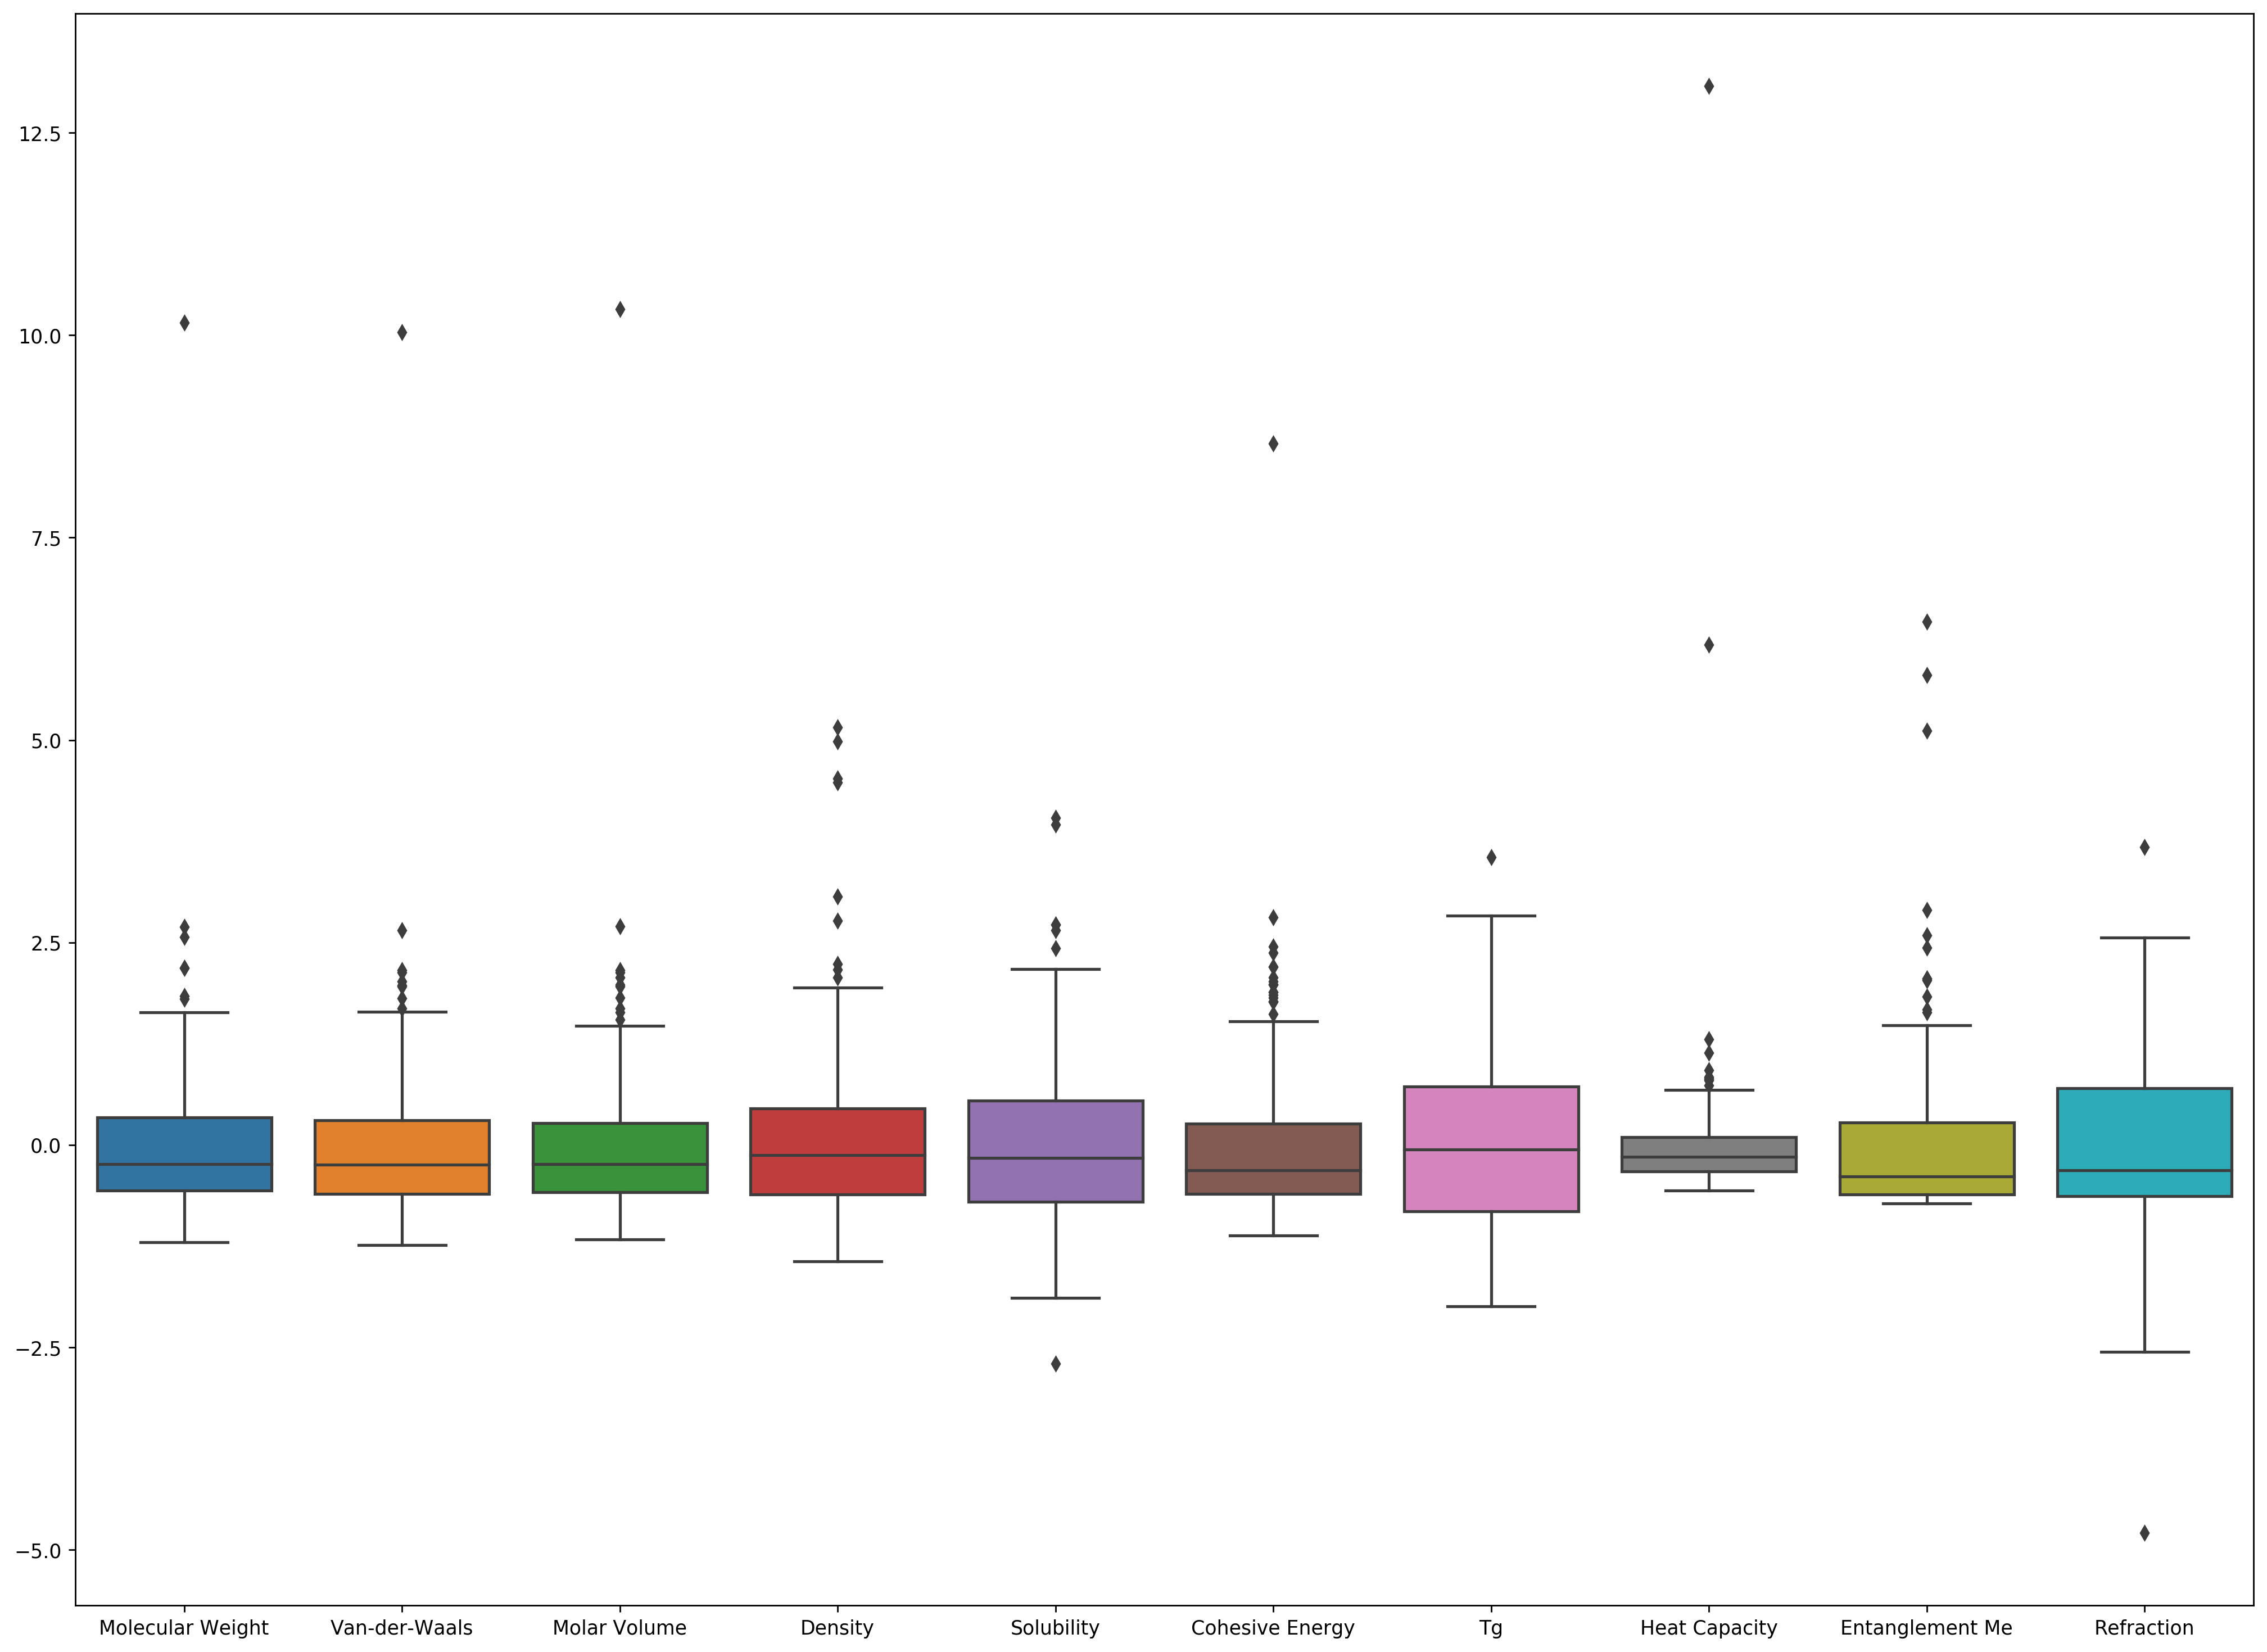

In [313]:
## Preparing data for box plots.

dfNumeric = dfPolymer[['Molecular Weight of Repeat unit', 'Van-der-Waals Volume VvW', 'Molar Volume Vm', 'Density ρ', 'Solubility Parameter δ', 'Molar Cohesive Energy Ecoh'
                     , 'Glass Transition Temperature Tg', 'Molar Heat Capacity Cp', 'Entanglement Molecular Weight Me', 'Index of Refraction n']].values

scalerNumeric = StandardScaler().fit(dfNumeric)
dfNumeric_norm = pd.DataFrame(scalerNumeric.transform(dfNumeric))
dfNumeric_norm.columns = ['Molecular Weight', 'Van-der-Waals', 'Molar Volume', 'Density', 'Solubility', 'Cohesive Energy'
                     , 'Tg', 'Heat Capacity', 'Entanglement Me', 'Refraction']

dBox = ['Molecular Weight', 'Van-der-Waals', 'Molar Volume', 'Density', 'Solubility', 'Cohesive Energy'
                     , 'Tg', 'Heat Capacity', 'Entanglement Me', 'Refraction']

fig = plt.figure(figsize =(20, 15), dpi=250) 


for i in dBox:
    dfBox = dfNumeric_norm.dropna(subset=[i])

sns.boxplot(data=dfBox)  

plt.show()

In general, the values are top heavy. In particular, there are some extreme cases / outliers. One of these is a super high molecular weight polyurethane, as an example. Heat capacity is fairly centralized. Solubility, Tg, and refraction have relatively large spreads.

## Visualization of Data
Currently almost all structural composites used in aerospace are thermoset based, and of that it is mostly epoxy or phenolic. There is great potential for the use of thermoplastic matrices. The biggest barriers to the use of thermoplastics in the past have been lower properties, solvent sensitivity, and low Tg. As a general rule, the higher the thermoplastic properties, the greater the contribution to the composite. The matrix is always far weaker than than the fiber reinforcement, and every bit of strength adds a large contribution due to the nature of the Rule of Mixtures [3]. This can be loosely represented by the crystallinity of a polymer. For the purposes of this project, crystallinity will be indirectly accounted for by the ratio of the Molar Volume to the Van der Waals Volume. Simply, the van der Waals volume is the theoretical smallest amount of space a polymer would take up if the polymer could be perfectly stacked and aligned with no space wasted [4]. Molar volume is the actual average volume of the molecule. Thus the ratio between the two is a representation of the close-packedness of the bulk molecule, which is indirectly representative of crystallinity [5]. Note, the inverse of this value is taken, so the higher the value the better.

Solvent resistance has traditionally kept many thermoplastics out of commercial aerospace [3]. One of the more aggressive solvents that polymers must survive is methyl ethyl ketone (there are worse offendors such as Skydrol, but a Hildebrand parameter could not be found). As a rule of thumb, if a solvent and polymer are within 3.6 MPa$^{1/2}$ then the polymer will be soluble [6]. MEK has a Solubility Parameter of 19.3 MPa$^{1/2}$ [7].

Lastly, polymers need to have a glass transition temperature (Tg) of at least 250$^{\circ}$F to allow for sufficient service temperature in commercial aerospace [8]. 

The list of polymers are filtered for the solubility and Tg, and the Tg is plotted against the molar volume to van der Waals ratio and polymer classes noted. This should provide a list of thermoplastics that could potentially be used for structural fiber reinforced thermoplastics in aerospace.

In [314]:
## Dropping polymers with no data, and calculating ratio of molar volume to van der Waals volume. Removing polymers with Tg < 250F.

dfPolymer = dfPolymer.dropna(subset=['Van-der-Waals Volume VvW'])
dfPolymer = dfPolymer.dropna(subset=['Molar Volume Vm'])
dfPolymer = dfPolymer.dropna(subset=['Solubility Parameter δ'])

dfPolymer['Ratio of Molar Volume and Van-der-Waals Volume'] = (dfPolymer['Molar Volume Vm']/dfPolymer['Van-der-Waals Volume VvW'])

dfDrop = dfPolymer.dropna(subset=['POLYMER CLASS'])
dfDrop = dfDrop[dfDrop['Glass Transition Temperature Tg'] >= 394]
dfDrop.shape

## Drop polymers susceptible to MEK

dfSolubility1 = dfDrop[dfDrop['Solubility Parameter δ'] > 22.9]
dfSolubility2 = dfDrop[dfDrop['Solubility Parameter δ'] < 15.7]

dfDrop = dfSolubility1.append(dfSolubility2)

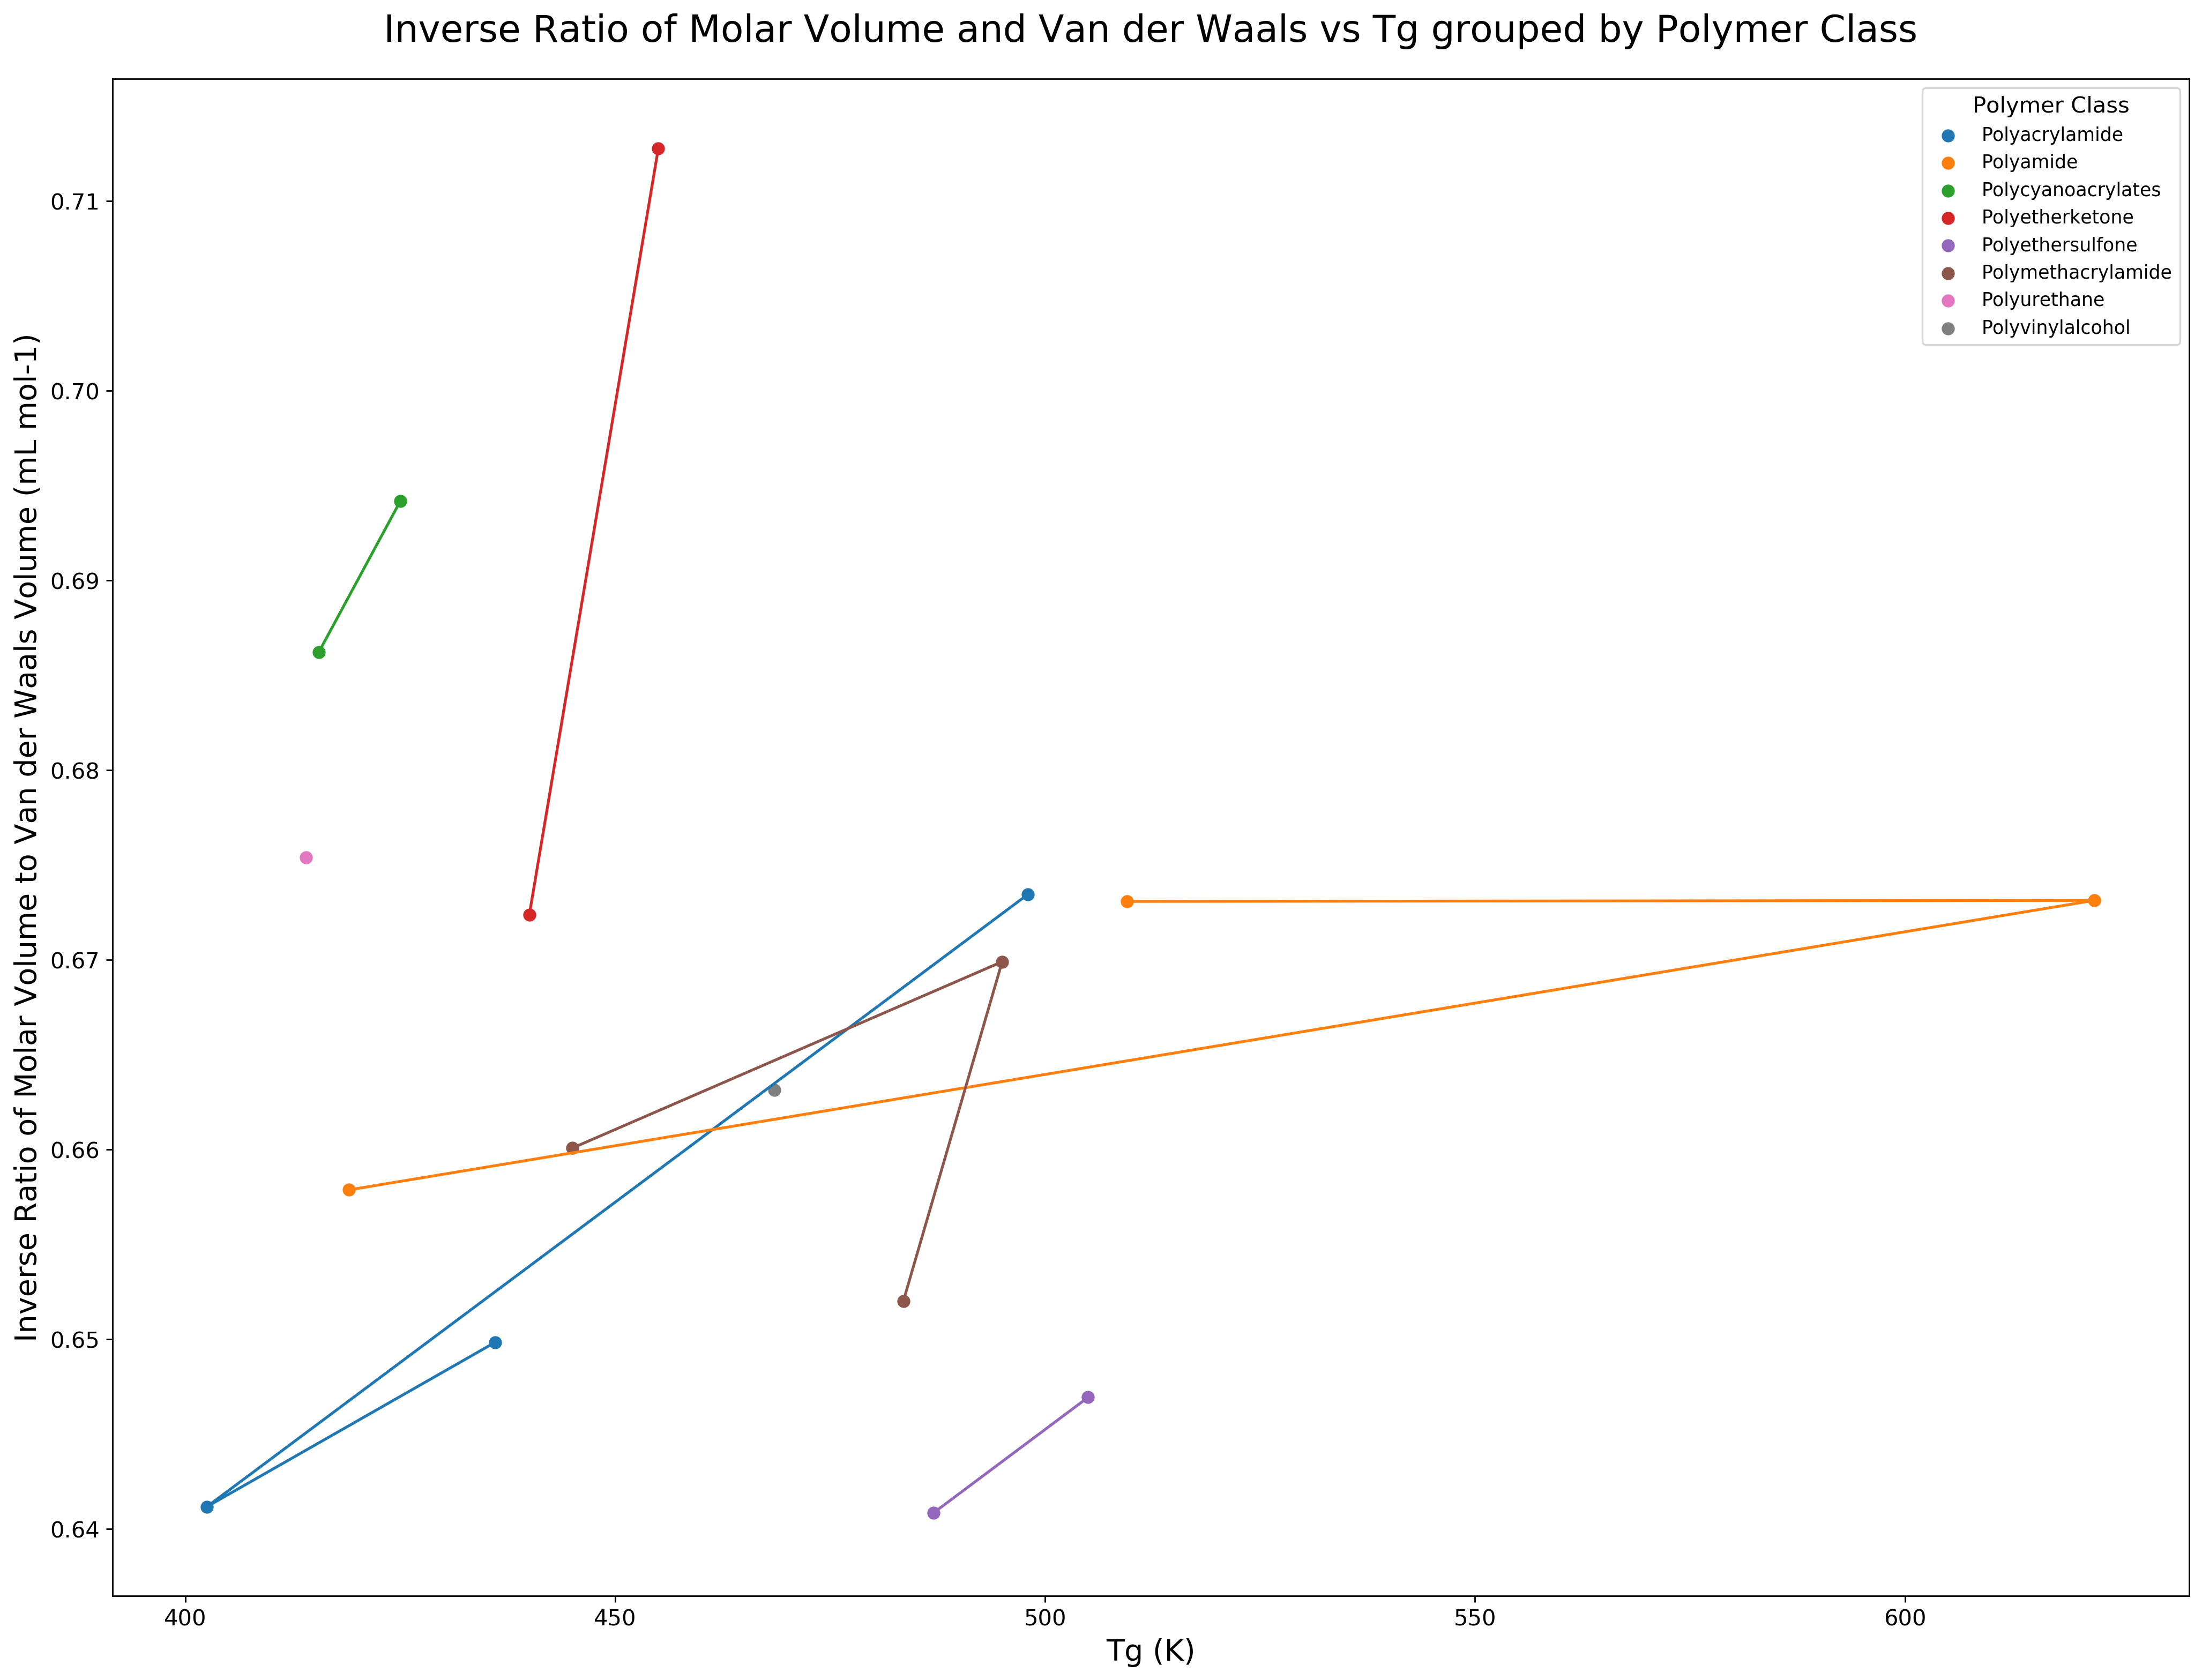

In [315]:
## Plotting the polymers that remain

fig = plt.figure(figsize = [20, 15], dpi=250)
ax = fig.add_subplot(111)

groups = dfDrop.groupby(['POLYMER CLASS'])

for name, group in groups: 
    x=group['Glass Transition Temperature Tg']
    y=1/group['Ratio of Molar Volume and Van-der-Waals Volume']
    ax.scatter(x, y, label = name)
    ax.plot(x, y)

plt.legend(loc='upper right', title="Polymer Class", title_fontsize = 12)
plt.xlabel('Tg (K)', fontsize=16)
plt.ylabel('Inverse Ratio of Molar Volume to Van der Waals Volume (mL mol-1)', fontsize=16)
plt.title('Inverse Ratio of Molar Volume and Van der Waals vs Tg grouped by Polymer Class', fontsize=20, pad=20)
plt.xlim()
plt.ylim()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Some of the remaining polymers are recognizable, such as polyetheretherketone (PEEK) which is the most common structural thermoplastic used in composites. Many of the polymers are new and suprising, so clearly there is more to the story than can be shown with these pieces of data. For example, some polymers such as cyanate esters can revert in the presence of humidity and heat, and this isn't readily apparent in the dataset. Further there are practical considerations as well. The class of polycyanoacrylates is essentially super glue and polymerizes quickly in the presence of moisture, and this would be difficult to use for any real sort of composite lay-up or storage of material [8].

## Questions to Answer
The intent is to use this database to see if there are thermoplastics or other polymers that could be useful for structural composites that have been neglected for whatever reason. There are many polymers of wide varieties and methodically working through a database of polymers should hopefully provide new insight.
## Pattern to Explore
Strings representing the chemical structures of the polymers are given as SMILES. It would be interesting to see if there is a relationship between the SMILES values, the Molar Volume to van der Waals ratio, and the Solubility Parameter. SMILES values will be converted into a number of descriptors from Mordred as a simplistic representation of the molecule.
## Feature Selection
As mentioned and explained previously, it would be useful to evaluate SMILES, Molar Volume to van der Waals ratio, and the Solubility Parameter. The Mordred descriptors to be evaluated will be the number of oxygen, nitrogen, carbon, and aromatic atoms. The Wiener Index will also be calculated as it provides some topographical information. These descriptors and Tg will be used to predict the Molar Volume to van der Waals ratio and the solubility parameter. 

## Cleaning and Processing Data
The extracted thermo-physical data was extracted mostly as strings listing ranges of values (e.g. 1.2 - 1.4). These values were taken and averaged, then reinserted. This process also removed any non-numeric .characters as it involved searching the strings for numbers. A few of the columns were removed because they didn't have much use, such as acronyms and structure (an image). The third table was also not extracted as it was experimental data, and was largely incomplete. Two data points only had experimental data, and were added back into the data set and noted as such.

After cleaning the data, there were some calculated values added. Specifically, the ratio between the Molar Volume and the van der Waals Volume was calculated. This ratio is an indication of how polymer chain packing, with a lower ratio indicating higher packing [5]. A higher amount of packing could indicate crystallinity, which is desired for aerospace use of thermoplastics. 

Lastly a number of Mordred descriptors were calculated using the RDKit package from the monomer SMILES information. Nitrogen and oxygen were chosen mainly because of their importance as chemical species, and other elements were left out for simplicity. Carbon was chosen as a replacement for total number of atoms. Total atoms would correlate with the other descriptors and number of carbon atoms has less colinearity but also has a similar effect. Aromatic atoms were chosen due to their significance in the polymer I am studying, which are polyarylketones. Lastly, the Wiener Index was chosen to provide a simple representation of topography of the molecule.

In [316]:
dfPolymer = dfPolymer.dropna(subset=['Monomer SMILES'])

In [317]:
## Process SMILES data

SMILES = []
for molecule in dfPolymer['Monomer SMILES']:
    SMILES.append(Chem.MolFromSmiles(molecule))

aList = np.arange(0, 238, 1)

NameError: name 'Chem' is not defined

In [ ]:
## Choosing some Mordred descriptors to process SMILES data
nO = descriptors.AtomCount.AtomCount('O')
nN = descriptors.AtomCount.AtomCount('N')
aromatic = descriptors.Aromatic.AromaticAtomsCount()
nC = descriptors.AtomCount.AtomCount('C')
WPath = descriptors.WienerIndex.WienerIndex(False)

## Adding these descriptors to data
OList = []
NList = []
aromaticList = []
CList = []
WList = []

for i in aList:
    if pd.isnull(SMILES[i]):
        SMILES[i] = np.nan
        OList.append(SMILES[i])
        NList.append(SMILES[i])
        aromaticList.append(SMILES[i])
        CList.append(SMILES[i])
        WList.append(SMILES[i])
    else: 
        OList.append(nO(SMILES[i]))
        NList.append(nN(SMILES[i]))
        aromaticList.append(aromatic(SMILES[i]))
        CList.append(nC(SMILES[i]))
        WList.append(WPath(SMILES[i]))

dfPolymer['Number of Oxygens'] = OList
dfPolymer['Number of Nitrogens'] = NList
dfPolymer['Number of Aromatic Atoms'] = aromaticList
dfPolymer['Number of Carbons'] = CList
dfPolymer['Wiener Index'] = WList

dfPolymerf = dfPolymer

In [ ]:
## Exporting data at this point so I don't have to reinstall rdkit

dfPolymerf.to_csv("all_polymer_df.csv")

In [ ]:
## Reading it back in

dfPolymerf = pd.read_csv('all_polymer_df.csv')
dfPolymerf = dfPolymerf.drop(['Unnamed: 0'], axis=1)

In [350]:
dfPolymerf.shape

(238, 26)

# Section 2 - Method
Minisom will be used to see what polymers are related with respect to Molar Volume to van der Waals Volume, solubility, number of oxygen, nitrogen, carbon, and aromatic atoms, and Wiener Index. The Minisom will have hyperparameters tuned, specifically sigma, learning rate, and size. The tuning will be based on reducing quantization and topographical error. After creating a grid, the point for PEEK will be found. Then the polymers on the same point and those within 1 point will be listed.

Note, index 123 in dfPolysub is the PEEK polymer that will be used for comparison.

Open a terminal, use the command:
`pip install minisom`

In [ ]:
import minisom
from minisom import MiniSom
import random

In [330]:
## Create a subset of pertinent information

dfPolysub = dfPolymerf[['POLYMER CLASS', 'COMMON NAMES', 'Glass Transition Temperature Tg','Ratio of Molar Volume and Van-der-Waals Volume', 'Solubility Parameter δ',
                  'Number of Oxygens','Number of Nitrogens','Number of Aromatic Atoms','Number of Carbons','Wiener Index']].copy()
dfPolysub.dropna(inplace=True)

## Set index
dfPolysub['index']=list(range(len(dfPolysub)))
dfPolysub.set_index('index',drop=True,inplace=True)

In [331]:
## Rename a couple unwieldy titles

dfPolysub = dfPolysub.rename(columns={'Ratio of Molar Volume and Van-der-Waals Volume':'Vm-Vv Ratio', 'Glass Transition Temperature Tg':'Tg', 'Solubility Parameter δ':'Solubility'})
dfPolysub

,POLYMER CLASS,COMMON NAMES,Tg,Vm-Vv Ratio,Solubility,Number of Oxygens,Number of Nitrogens,Number of Aromatic Atoms,Number of Carbons,Wiener Index
index,,,,,,,,,,
0,Polyvinylsulfide,"Poly(propyl vinyl thioether), Poly(vinyl propy...",250.5,1.629690,17.60,0.0,0.0,0.0,5.0,35.0
1,Polyvinylsulfide,"Poly(vinyl phenyl sulfide), Poly(phenylthioeth...",398.0,1.518173,19.85,0.0,0.0,6.0,8.0,94.0
2,Polyvinylsulfide,"Poly(methyl vinyl thioether), Poly(vinyl methy...",269.5,1.622517,18.20,0.0,0.0,0.0,3.0,10.0
3,Polyvinylsulfide,"Poly(ethyl vinyl thioether), Poly(vinyl ethyl ...",265.0,1.608227,17.85,0.0,0.0,0.0,4.0,20.0
4,Polyvinylsulfide,"Poly(butyl vinyl thioether), Poly(vinyl butyl ...",259.5,1.592877,17.50,0.0,0.0,0.0,6.0,56.0
...,...,...,...,...,...,...,...,...,...,...
229,Polyacrylamide,Poly(N-phenylacrylamide),498.0,1.484888,25.85,1.0,1.0,6.0,9.0,168.0
230,Polyacrylamide,"Poly(N-tert-butyl acrylamide), Poly[N-(2-methy...",417.5,1.550569,22.45,1.0,1.0,0.0,7.0,94.0
231,Polyacrylamide,Poly(N-octyl acrylamide),228.0,1.551738,20.95,1.0,1.0,0.0,11.0,346.0


In [332]:
## Create a training data set

train = dfPolysub[['Vm-Vv Ratio', 'Solubility', 'Number of Oxygens','Number of Nitrogens', 'Number of Aromatic Atoms', 'Number of Carbons', 'Wiener Index']].values
train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)

In [333]:
## Define a SOM, starting with a basic 10x10 to see what it looks like.
height = 10
width = 10
# Define a MiniSom object
SOM = MiniSom(width, height, train.shape[1], sigma=1.0, learning_rate=0.5,neighborhood_function='gaussian', random_seed=100) 

## Initialize weights by PCA
SOM.pca_weights_init(train)

## Trains the SOM with 500 iterations
SOM.train(train, 500) 

In [334]:
## Checking PEEK

SOM.winner(train[123])

(0, 4)

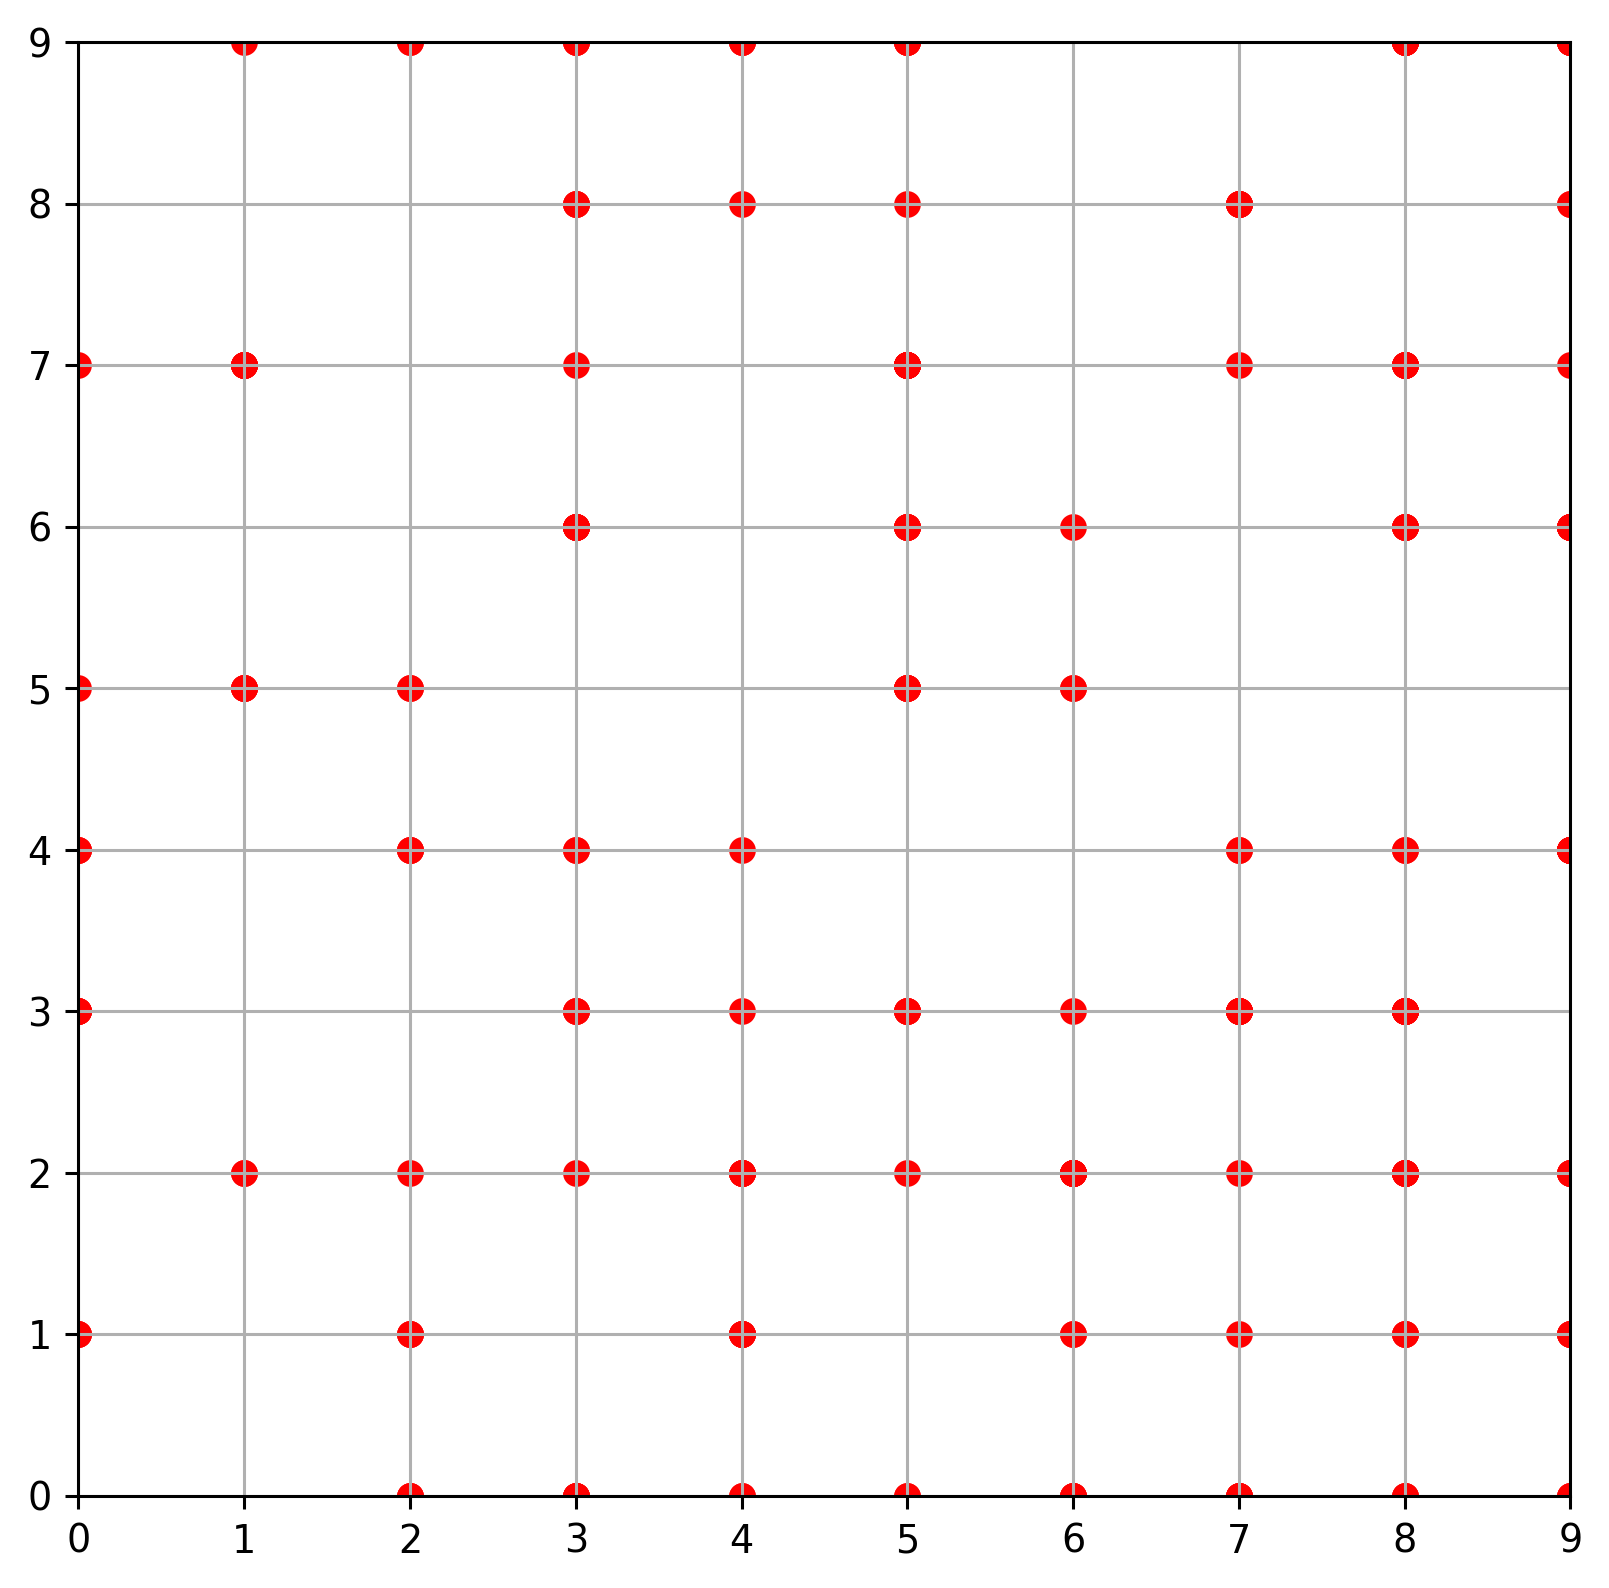

In [335]:
## Plotting the first run

fig = plt.figure(figsize=(7, 7),dpi=275)
ax = fig.add_subplot(111)

for index, datapoint in enumerate(train):
    dimension = SOM.winner(datapoint)
    x = dimension[0]
    y = dimension[1]
    
    plt.scatter(x,y,c='red')
 
plt.ylim(0,height-1)
plt.xlim(0,width-1)
ax.set_xticks(range(width))
ax.set_yticks(range(height))
plt.grid()

In [336]:
## Tuning the size

size_list = np.arange(5,40,1)
te = [0]*len(size_list)
qe = [0]*len(size_list)

for i in range(len(size_list)):
    SOM = MiniSom(size_list[i], size_list[i], train.shape[1], sigma=1.0, learning_rate=0.5,neighborhood_function='gaussian', random_seed=100)
    SOM.pca_weights_init(train)
    SOM.train(train, 500)
    te[i] = SOM.topographic_error(train)
    qe[i] = SOM.quantization_error(train)

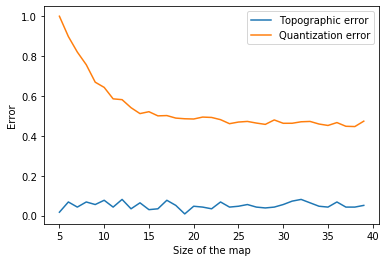

In [337]:
## Plotting the error against different sizes.

plt.plot(size_list,te,label='Topographic error')
plt.plot(size_list,qe,label='Quantization error')
plt.xlabel('Size of the map')
plt.ylabel('Error')
plt.legend()
plt.show()

Based on this graph, a 13x13 grid minimizes topographic error while passing the knee on quantization error. This will be used going forward.

In [338]:
## Tuning for sigma

size_list = np.arange(0.5,5.5,0.5)
te = [0]*len(size_list)
qe = [0]*len(size_list)

for i in range(len(size_list)):
    height = 13
    width = 13
    SOM = MiniSom(width, height, train.shape[1], sigma=size_list[i], learning_rate=0.5,neighborhood_function='gaussian', random_seed=100)
    SOM.pca_weights_init(train)
    SOM.train(train, 500)
    te[i] = SOM.topographic_error(train)
    qe[i] = SOM.quantization_error(train)


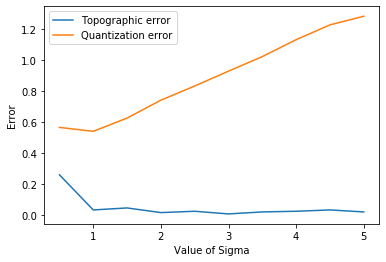

In [339]:
## Plotting the error against different sigma values.

plt.plot(size_list,te,label='Topographic error')
plt.plot(size_list,qe,label='Quantization error')
plt.xlabel('Value of Sigma')
plt.ylabel('Error')
plt.legend()
plt.show()

Based on this graph, sigma=1.0 has the lowest topographic and quantization error. A lower value also minimizes quantization as it goes up as sigma goes up.

In [340]:
## Tuning learning rate

size_list = [0.5, 0.25, 0.1, 0.03, 0.01]
te = [0]*len(size_list)
qe = [0]*len(size_list)

for i in range(len(size_list)):
    height = 13
    width = 13
    SOM = MiniSom(width, height, train.shape[1], sigma=1.0, learning_rate=size_list[i] ,neighborhood_function='gaussian', random_seed=100)
    SOM.pca_weights_init(train)
    SOM.train(train, 500)
    te[i] = SOM.topographic_error(train)
    qe[i] = SOM.quantization_error(train)

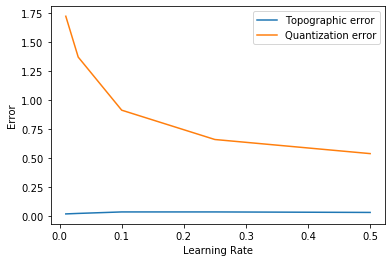

In [341]:
## Plotting the error against different learning rates.

plt.plot(size_list,te,label='Topographic error')
plt.plot(size_list,qe,label='Quantization error')
plt.xlabel('Learning Rate')
plt.ylabel('Error')
plt.legend()
plt.show()

It looks like a learning rate of 0.5 minimizes both errors.

In [342]:
## Defining the tuned SOM
height = 13
width = 13
## Defining the final MiniSOM object, dropping the random seed
SOMfinal = MiniSom(width, height, train.shape[1], sigma=1.0, learning_rate=0.5,neighborhood_function='gaussian') 

## Initialize weights by PCA
SOMfinal.pca_weights_init(train)

SOMfinal.train(train, 500) 

In [343]:
## Checking errors to ensure they are still about the same without random seed.

print('Topographic error: ', SOMfinal.topographic_error(train))
print('Quantization error: ', SOMfinal.quantization_error(train))

Topographic error:  0.03418803418803419
Quantization error:  0.5407487197484914


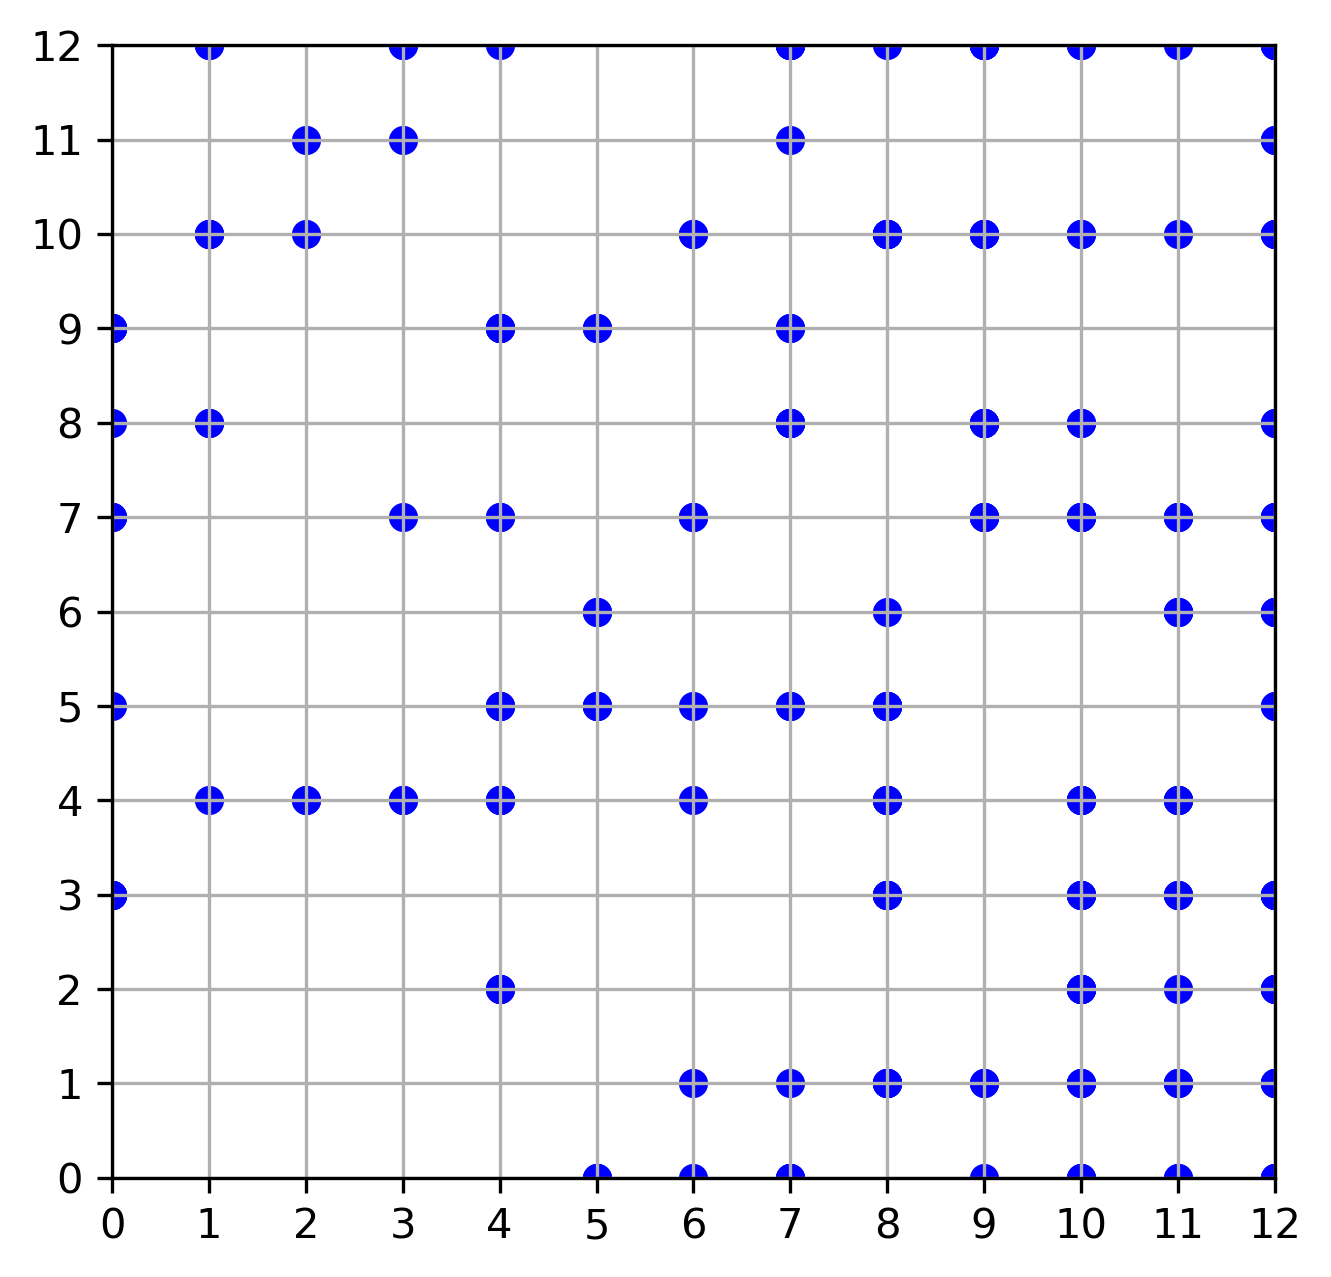

In [344]:
## Plotting the final SOM.

fig = plt.figure(figsize=(5, 5),dpi=300)
ax = fig.add_subplot(111)

for index, datapoint in enumerate(train):
    dimension = SOMfinal.winner(datapoint)
    x = dimension[0]
    y = dimension[1]
    
    plt.scatter(x,y,c='blue')
       
plt.ylim(0,height-1)
plt.xlim(0,width-1)
ax.set_xticks(range(width))
ax.set_yticks(range(height))
plt.grid()

In [345]:
## First the point on the SOM for PEEK will be found, which is index 123.

SOMfinal.winner(train[123])

(4, 5)

In [346]:
## Here, a list of the polymers in the same point as PEEK are put into a dataframe

aList =[]

for index, datapoint in enumerate(train):
    # find the best matching unit of the datapoint
    dimension = SOMfinal.winner(datapoint)
    x = dimension[0]
    y = dimension[1]
    if x == 4 and y == 5:
        aList.append(index)
On = []
for i in aList:
    On.append(dfPolysub.loc[i])

dfOn = pd.DataFrame(On)
dfOn

,POLYMER CLASS,COMMON NAMES,Tg,Vm-Vv Ratio,Solubility,Number of Oxygens,Number of Nitrogens,Number of Aromatic Atoms,Number of Carbons,Wiener Index
78,Polyethersulfone,"Poly(ether ether sulfone), Poly(1,4-phenylene ...",487.0,1.560442,23.55,4.0,0.0,18.0,18.0,1.360000e+10
123,Polyetherketone,"Poly(ether ether ketone), Poly[(hydroquinone)-...",418.5,1.532587,22.40,3.0,0.0,18.0,19.0,1.600000e+10
124,Polyetherketone,"Poly(ether ether ketone), Cypec® PEKK, Oxpekk®...",440.0,1.487283,23.30,3.0,0.0,18.0,20.0,1.560000e+10


In [347]:
## Here polymers in points 1 point from PEEK are put into a dataframe.

aListNearby =[]

for index, datapoint in enumerate(train):
    # find the best matching unit of the datapoint
    dimension = SOMfinal.winner(datapoint)
    x = dimension[0]
    y = dimension[1]
    if x == 4 and y == 4:
        aListNearby.append(index)
    elif x == 3 and y == 4:
        aListNearby.append(index)
    elif x == 5 and y == 5:
        aListNearby.append(index)
    elif x == 5 and y == 6:
        aListNearby.append(index)

Nearby = []
for i in aListNearby:
    Nearby.append(dfPolysub.loc[i])
    
dfNearby = pd.DataFrame(Nearby)
dfNearby

,POLYMER CLASS,COMMON NAMES,Tg,Vm-Vv Ratio,Solubility,Number of Oxygens,Number of Nitrogens,Number of Aromatic Atoms,Number of Carbons,Wiener Index
75,Polyethersulfone,"Bisphenol A Polysulfone, Poly{[bis(4-chlorophe...",459.5,1.554716,21.65,4.0,0.0,24.0,27.0,2.890000e+10
76,Polyethersulfone,"Poly(phenylsulfone), Poly(1,4-biphenyl ether e...",482.0,1.552398,22.70,4.0,0.0,24.0,24.0,2.380000e+10
77,Polyethersulfone,"Poly(ethersulfone), Poly(1,4-phenylene ether-s...",505.0,1.545738,24.70,6.0,0.0,24.0,24.0,2.890000e+10
82,Epoxy Resin,Bisphenol-A diglycidyl ether epoxy or phenoxy ...,380.5,1.577444,21.30,3.0,0.0,12.0,18.0,8.500001e+09
97,Polycarbonates,Poly(tetramethyl Bisphenol A carbonate),459.0,1.587652,18.50,3.0,0.0,12.0,20.0,8.400001e+09
98,Polycarbonates,"Poly(2,6,3',5'-tetrachloro bisphenol A carbonate)",478.5,1.581348,20.80,3.0,0.0,12.0,16.0,8.400001e+09
102,Polycarbonates,Poly(bisphenol B carbonate),414.0,1.495701,20.10,3.0,0.0,12.0,17.0,7.200001e+09
104,Polycarbonates,"Poly(bisphenol A carbonate), Lexan™, Makrolon®",428.5,1.491272,20.35,3.0,0.0,12.0,16.0,6.800001e+09
144,Polyesters,Poly(Bisphenol A terephthalate),467.5,1.475721,20.55,6.0,0.0,18.0,23.0,2.040000e+10
145,Polyesters,Poly(bisphenol A isophthalate),453.5,1.475721,20.55,6.0,0.0,18.0,23.0,2.040000e+10


# Section 3 - Results
The lists obtained in Section 2 are combined and plotted in the same way as what was done in Section 1. The results are similar, except that there are less options. Interestingly, the polymers identified are all those used in aerospace. Epoxy is a thermoset, and is the most widely used polymer in fiber reinforced polymers. The polyetherketones are the most common semi-crystalline thermoplastic used, and polyethersulfone is another commonly used one [8].

Polyester is widely used, but almost exclusively in the pressurized part of the airplane as the elements have been known to degrade polyester unless it is fully contained. As a matrix it would not work in exterior applications. It is interesting to see that the polyesters evaluated here have higher packing factors than PEEK [9].

Polycarbonate is interesting and not one that is typically used. It is on the lower end of crystallinity, though, and has far higher Tg than PEEK. It seems like it would be better to use PEEK because it has higher crystallinity and can be used with lower processing temperatures [8].

It should be noted that most of these options would not pass MEK exposure, but that just means it can't be used in exterior primary structure. There are still applications in secondary and interior structure (and they are used here) [9].

Comparing to the list of polymers from Section 1, the following polymers were not identified by SOM:
- polyacrylamide
- polyamide
- polycyanoacrylates
- polymethacrylamide
- polyurethane
- polyvinylachol

This means that these options could be potentially useful as they are significantly different from the go-to crystalline polymer PEEK. These might provide new options for fiber reinforced thermoplastics in aerospace. More work would need to be done to ensure there are no additional issues as there are many factors to consider for aerospace such as fungal resistance, hot wet effect, mechanical properties, creep, fatigue, and fracture resistance [10].

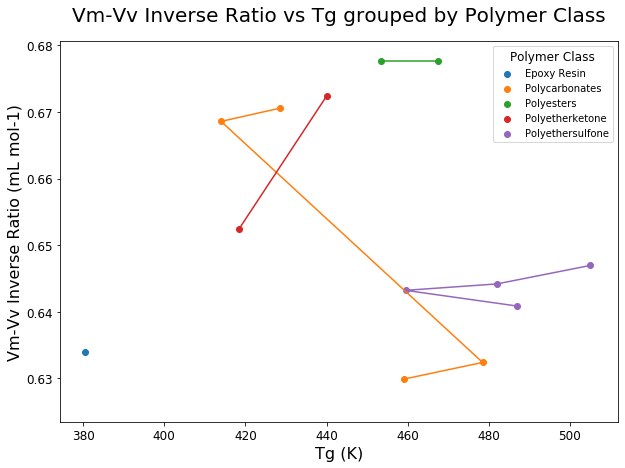

In [349]:
## Plotting the polymers that remain

dfCombined = dfOn.append(dfNearby)

fig = plt.figure(figsize = [10, 7])
ax = fig.add_subplot(111)

groups = dfCombined.groupby(['POLYMER CLASS'])

for name, group in groups: 
    x=group['Tg']
    y=1/group['Vm-Vv Ratio']
    ax.scatter(x, y, label = name)
    ax.plot(x, y)

plt.legend(loc='upper right', title="Polymer Class", title_fontsize = 12)
plt.xlabel('Tg (K)', fontsize=16)
plt.ylabel('Vm-Vv Inverse Ratio (mL mol-1)', fontsize=16)
plt.title('Vm-Vv Inverse Ratio vs Tg grouped by Polymer Class', fontsize=20, pad=20)
plt.xlim()
plt.ylim()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# References
1. http://www.polymerdatabase.com/home.html
2. http://polymerdatabase.com/polymer%20physics/GIM-TG.html
3. https://doi.org/10.1016/B978-0-08-102131-6.00002-5
4. http://polymerdatabase.com/polymer%20physics/vdWVolume.html
5. https://polymerdatabase.com/polymer%20physics/MolarVolume.html
6. https://polymerdatabase.com/polymer%20physics/Polymer%20Solubility.html
7. https://cool.culturalheritage.org/coolaic/sg/bpg/annual/v03/bp03-04.html
8. https://www.aerodefensetech.com/component/content/article/adt/features/articles/32727
9. https://www.assemblymag.com/articles/94125-the-growing-role-of-plastics-in-aerospace-assembly
10. https://www.researchgate.net/publication/257748047_The_Role_of_Advanced_Polymer_Materials_in_Aerospace